In [51]:
import os
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipd

In [52]:
## This method is used for the local dataset that has already been downloaded to the Learn enviornment.
#tf.keras.utils.get_file(
#     'speech_commands_v0.02.tar.gz',
#      origin = "./data/speech_commands_v0.02.tar.gz",/Users/andavaro/Desktop/Andrès/UBA/Trabajo de grado CEIA/VENV Python/Tesis_IA/data/speech_commands_v0.02.tar.gz
#      extract=True,
#      cache_dir='.', cache_subdir='data')

In [53]:
## This method is for local development to download from the public storage location.
#
# data_dir = pathlib.Path('./data/mini_speech_commands')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [54]:
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        
    return dataset

In [77]:
# Change directory to downloaded data
DATASET_PATH = '/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
os.chdir(DATASET_PATH)
default_dir = os.getcwd()
print(f'Data directory will be: {default_dir}')

Data directory will be: /Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands


In [56]:
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Labels: {len(labels)}')
print(f'Label Names: {labels}')

Total Labels: 8
Label Names: ['right', 'go', 'no', 'left', 'stop', 'up', 'down', 'yes']


In [57]:
filenames = tf.io.gfile.glob(str(default_dir) + '/*/*')
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Number of total examples: 8000


In [58]:
file_path = "./yes/00f0204f_nohash_0.wav"

def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate.numpy()

waveform, sample_rate = load_audio(file_path)
print('Waveform Tensor:', waveform)
print('Sample Rate:', sample_rate)

Waveform Tensor: tf.Tensor([0.00042725 0.0007019  0.00057983 ... 0.00057983 0.00067139 0.00073242], shape=(16000,), dtype=float32)
Sample Rate: 16000


In [59]:
def plot_audio(filename):
    waveform, sample_rate = load_audio(filename)

    plt.figure()
    plt.plot(waveform.numpy())

    return waveform, sample_rate

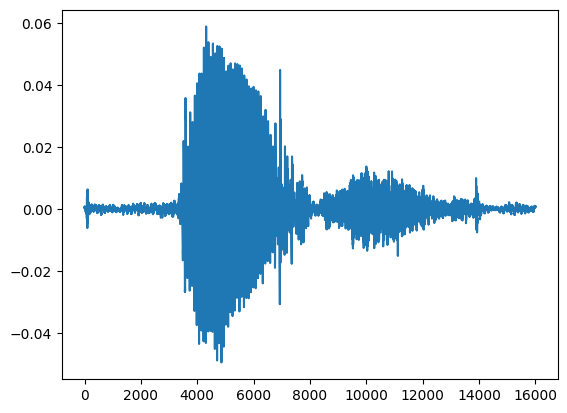

In [60]:
filename = "./yes/00f0204f_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

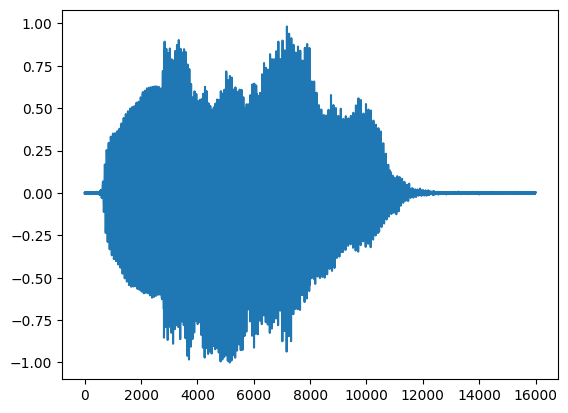

In [61]:
filename = "./no/0c2ca723_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Data visualization and transformation is an important part of every model. Now that we have our dataset downloaded, let's learn more about audio data visualization and transforming this dataset. We will be using tf.signal and tfio.audio processing operations to transform the data. Once we understand these concepts we will create our spectrogram images of the yes/no dataset to be used in the computer vision model.

## Load the dataset
Here we import the packages and create a load_audio and load_audio_files function to load audio files from a specified path into a dataset.

In [62]:
import tensorflow.io as tfio
from pathlib import Path
import numpy as np

In [63]:
trainset_speechcommands_yes = load_audio_files('/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/yes', 'yes')
trainset_speechcommands_no = load_audio_files('/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/no', 'no')

print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 1000
Length of no dataset: 1000


In [64]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]}')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: [-0.0027771  -0.00537109 -0.00338745 ... -0.00112915 -0.00131226
 -0.00140381]
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714
No Waveform: [0.00720215 0.00610352 0.00552368 ... 0.00979614 0.0085144  0.00921631]
No Sample Rate: 16000
No Label: no
No ID: 012c8314


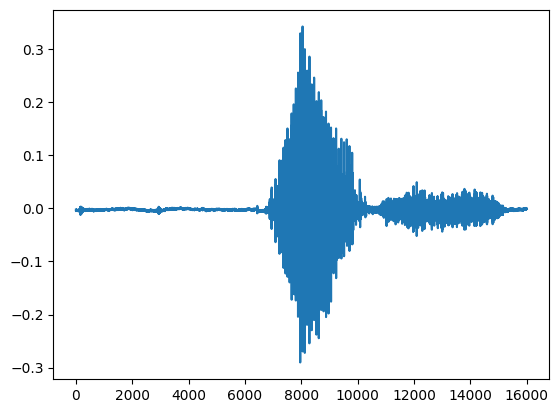

In [65]:
timescale = np.arange(yes_waveform.shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, yes_waveform.numpy())
plt.show()

In [66]:
def get_spectrogram(waveform):
    
    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)
    
    # Option 1: Use tfio to get the spectrogram
    #spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)
    
    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram#, spect

## This funciton has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

In [67]:
spectrogram= get_spectrogram(yes_waveform)

print('Label:', 'yes')
print('Waveform shape:', yes_waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
#print('Spect shape:', spect.shape)
print('Audio playback')
ipd.Audio(yes_waveform.numpy(), rate=16000)

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


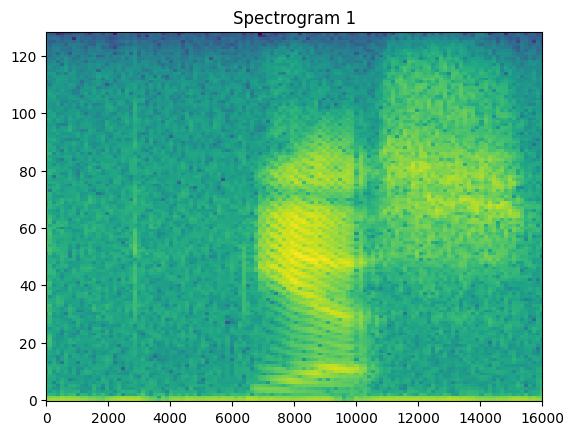

In [68]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)
    
fig, ax = plt.subplots()  
plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1')
plt.show()

#fig, ax = plt.subplots()  
#plot_spectrogram(spect.numpy(), ax, 'Spectrogram 2')
#plt.show()


In [114]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = np.delete(commands, 2)
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [115]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Filenames: ', filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Filenames:  tf.Tensor(
[b'/Users/andavaro/Desktop/Andre\xcc\x80s/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/no/ac652c60_nohash_0.wav'
 b'/Users/andavaro/Desktop/Andre\xcc\x80s/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/down/bf5d409d_nohash_0.wav'
 b'/Users/andavaro/Desktop/Andre\xcc\x80s/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/down/42beb5eb_nohash_0.wav'
 ...
 b'/Users/andavaro/Desktop/Andre\xcc\x80s/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/down/1e9b215e_nohash_0.wav'
 b'/Users/andavaro/Desktop/Andre\xcc\x80s/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/stop/6727b579_nohash_4.wav'
 b'/Users/andavaro/Desktop/Andre\xcc\x80s/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands/stop/b0f24c9b_nohash_1.wav'], shape=(8000,), dtype=string)
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'/Use

# Train/Val/Test

In [116]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [117]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [118]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [119]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [120]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [121]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

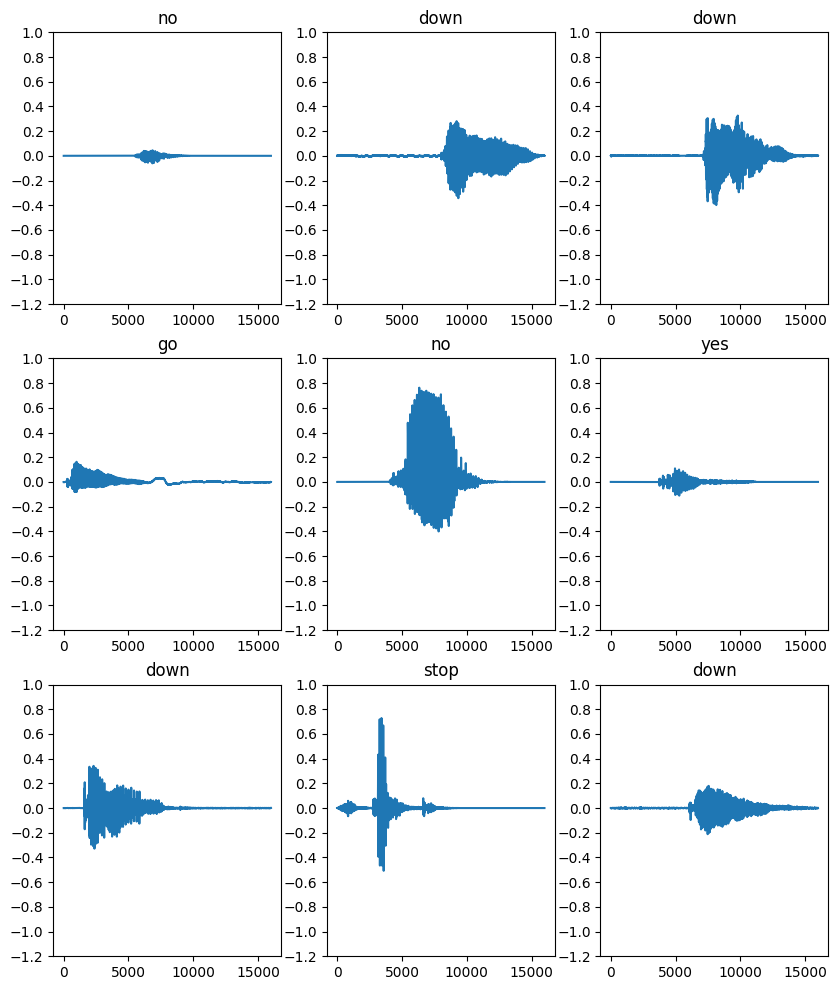

In [122]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# Espectogramas

In [123]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [124]:
from IPython import display
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

In [126]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

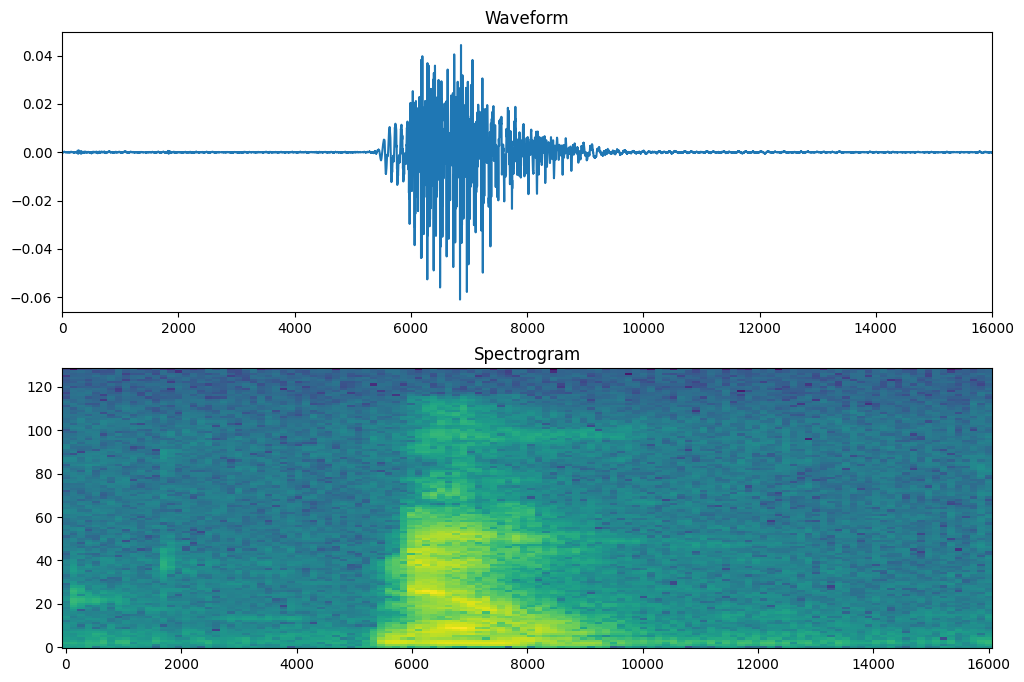

In [127]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()



In [128]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [129]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

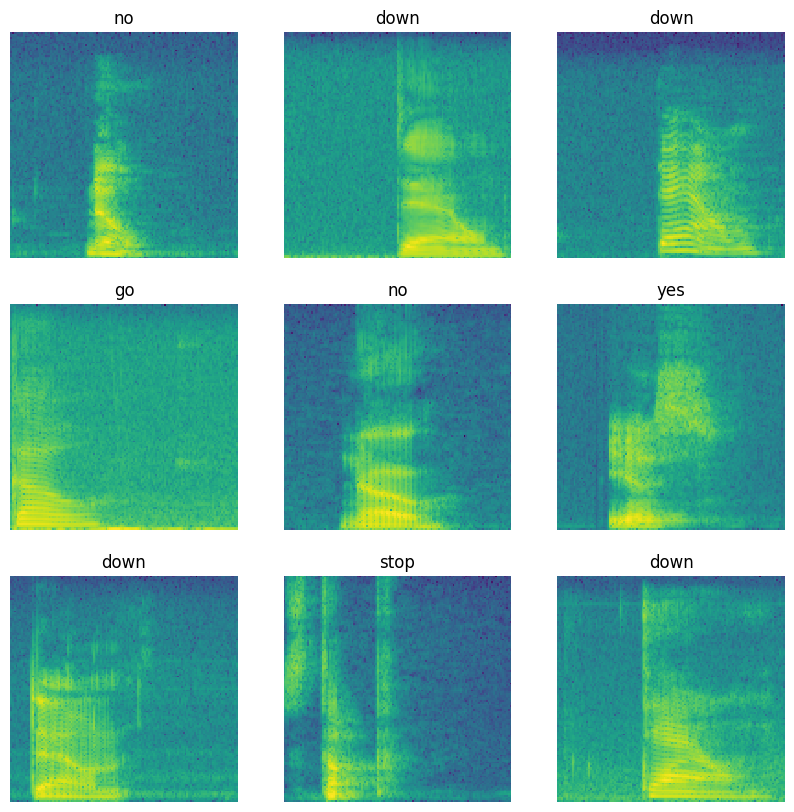

In [130]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Preprocess dataset

In [131]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [132]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [133]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [134]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Modelo 1

In [135]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2023-07-18 16:47:46.599387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-18 16:47:46.611781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)       

In [136]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [137]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2023-07-18 16:47:58.510942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8938 - accuracy: 0.3278

2023-07-18 16:48:01.399950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 3s 29ms/step - loss: 1.8938 - accuracy: 0.3278 - val_loss: 1.4577 - val_accuracy: 0.4887
Epoch 2/10
100/100 [==============================] - 2s 18ms/step - loss: 1.4451 - accuracy: 0.5455 - val_loss: 1.3675 - val_accuracy: 0.5962
Epoch 3/10
100/100 [==============================] - 2s 19ms/step - loss: 1.4484 - accuracy: 0.6337 - val_loss: 2.1162 - val_accuracy: 0.5763
Epoch 4/10
100/100 [==============================] - 2s 19ms/step - loss: 1.9009 - accuracy: 0.6536 - val_loss: 3.7380 - val_accuracy: 0.5813
Epoch 4: early stopping


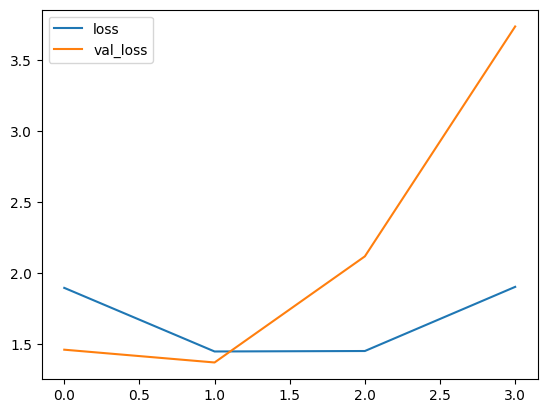

In [139]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [140]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

18/25 [====================>.........] - ETA: 0s

2023-07-18 16:49:33.228650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 0s 6ms/step
Test set accuracy: 62%


In [147]:
import seaborn as sns

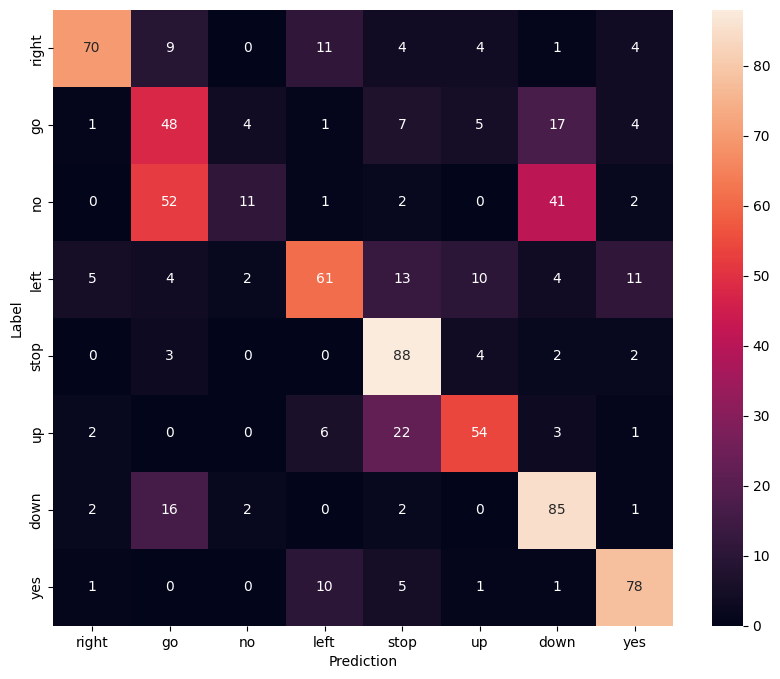

In [148]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Modelo 2

In [170]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model2.summary()

Input shape: (124, 129, 1)


2023-07-18 17:45:19.552156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-18 17:45:19.564885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 122, 127, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 61, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 59, 61, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 29, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 55680)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [171]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [172]:
EPOCHS = 10
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-18 17:45:30.751078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.6305 - accuracy: 0.4698

2023-07-18 17:45:39.247331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 9s 88ms/step - loss: 1.6305 - accuracy: 0.4698 - val_loss: 1.2580 - val_accuracy: 0.5838
Epoch 2/10
100/100 [==============================] - 9s 86ms/step - loss: 0.9881 - accuracy: 0.7153 - val_loss: 1.4307 - val_accuracy: 0.7000
Epoch 3/10
100/100 [==============================] - 9s 86ms/step - loss: 1.0623 - accuracy: 0.7609 - val_loss: 2.5008 - val_accuracy: 0.6825
Epoch 3: early stopping


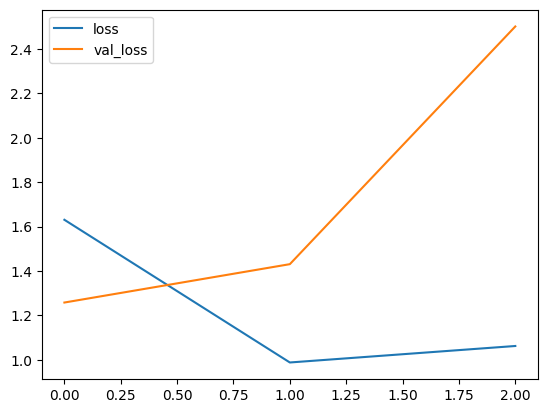

In [173]:
metrics2 = history2.history
plt.plot(history2.epoch, metrics2['loss'], metrics2['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [174]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model2.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

11/25 [============>.................] - ETA: 0s

2023-07-18 17:45:57.215569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 0s 17ms/step
Test set accuracy: 72%


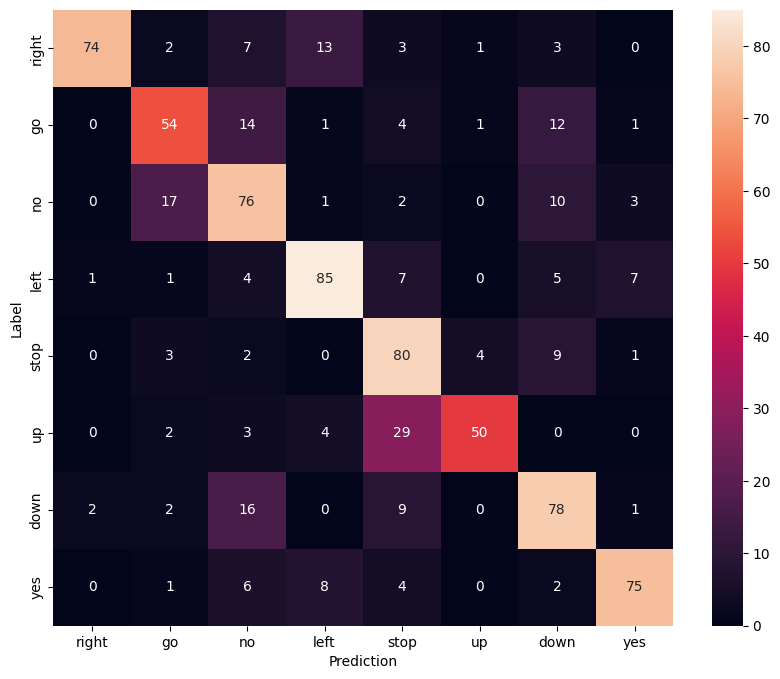

In [175]:
confusion_mtx2 = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx2,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()